<a href="https://colab.research.google.com/github/mrarnoldy18/Konversi-Luaran-Data-Mining/blob/main/Project_Konversi_Data_Mining_Arnoldy_23082010084.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\textbf{Project Konversi} $ <br>
$\textbf{Data Mining} $ <br>

Arnoldy Mahesa Riadhino <BR>
23082010084 <BR>

Judul dataset : Our World In Data-COVID-19

$\textbf{1. SETUP & DATA ACQUISITION} $ <br>

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download dataset via KaggleHub (API)
path = kagglehub.dataset_download("caesarmario/our-world-in-data-covid19-dataset")
print("Path to dataset files:", path)

# Memuat data (asumsi file utama berformat .csv)
import os
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

100%|██████████| 13.6M/13.6M [00:00<00:00, 103MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/caesarmario/our-world-in-data-covid19-dataset/versions/432


$\textbf{2. DATA PREPROCESSING} $ <br>

In [ ]:
print("Jumlah baris & kolom:", df.shape)
df.info()
df.describe()

print("Jumlah Missing Value per Kolom:")
print(df.isna().sum())

# persentase missing values
missing_percent = (df.isna().sum() / len(df)) * 100
print("\nPersentase Missing Value (%):")
print(missing_percent)

required_cols = ["location","date","total_cases","total_deaths","population"]

df = df.dropna(subset=required_cols)
print("Data setelah menghapus missing values:", df.shape)

print("Jumlah data duplikat:", df.duplicated().sum())

# hapus duplikat jika ada
df = df.drop_duplicates()
print("Data setelah menghapus duplikat:", df.shape)

# cek nilai negatif
for col in ["total_cases","new_cases","total_deaths","population"]:
    print(col, "nilai negatif =", (df[col] < 0).sum())

# hapus baris tidak logis
df = df[df["total_cases"] >= 0]
df = df[df["total_deaths"] >= 0]
df = df[df["population"] > 0]

print("Data setelah logical cleaning:", df.shape)





Jumlah baris & kolom: (290249, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 290249 entries, 81 to 350084
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   location           290249 non-null  object        
 1   date               290249 non-null  datetime64[ns]
 2   total_cases        290249 non-null  float64       
 3   new_cases          290249 non-null  float64       
 4   total_deaths       290249 non-null  float64       
 5   population         290249 non-null  float64       
 6   cases_per_million  290249 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.7+ MB
Jumlah Missing Value per Kolom:
location             0
date                 0
total_cases          0
new_cases            0
total_deaths         0
population           0
cases_per_million    0
dtype: int64

Persentase Missing Value (%):
location             0.0
date                 0

RINGKASAN DATA PRE-PROCESSING

In [ ]:
print("== STATUS AKHIR DATA ==")
print("Jumlah baris & kolom:", df.shape)
print("\nSisa Missing Values:")
print(df.isna().sum())

print("\nContoh 5 data setelah preprocessing:")
df.head()


== STATUS AKHIR DATA ==
Jumlah baris & kolom: (290249, 7)

Sisa Missing Values:
location             0
date                 0
total_cases          0
new_cases            0
total_deaths         0
population           0
cases_per_million    0
dtype: int64

Contoh 5 data setelah preprocessing:


,location,date,total_cases,new_cases,total_deaths,population,cases_per_million
81,Afghanistan,2020-03-24,40.0,16.0,1.0,41128772.0,0.972555
82,Afghanistan,2020-03-25,42.0,2.0,1.0,41128772.0,1.021183
83,Afghanistan,2020-03-26,74.0,32.0,1.0,41128772.0,1.799227
84,Afghanistan,2020-03-27,74.0,0.0,1.0,41128772.0,1.799227
85,Afghanistan,2020-03-28,80.0,6.0,2.0,41128772.0,1.945110


$\textbf{3. EDA} $ <br>

3.1 Agregasi per Negara

In [ ]:
global_mean = df.groupby("location").agg({
    "cases_per_million":"mean",
    "total_deaths":"max",
    "population":"max"
}).reset_index()

global_mean.head()


,location,cases_per_million,total_deaths,population
0,Afghanistan,3339.494547,7952.0,4.112877e+07
1,Africa,5738.661398,259023.0,1.426737e+09
2,Albania,69285.222040,3604.0,2.842318e+06
3,Algeria,4167.326737,6881.0,4.490323e+07
4,American Samoa,175715.792086,34.0,4.429500e+04


3.2 Analisis Distribusi Kasus

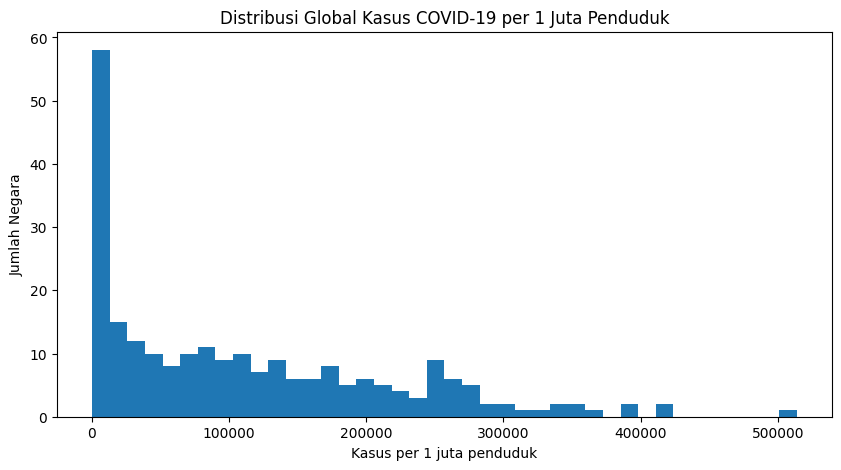

In [ ]:

plt.figure(figsize=(10,5))
plt.hist(global_mean["cases_per_million"], bins=40)
plt.xlabel("Kasus per 1 juta penduduk")
plt.ylabel("Jumlah Negara")
plt.title("Distribusi Global Kasus COVID-19 per 1 Juta Penduduk")
plt.show()


3.3 Analisis Top-10 Negara Kasus Tertinggi

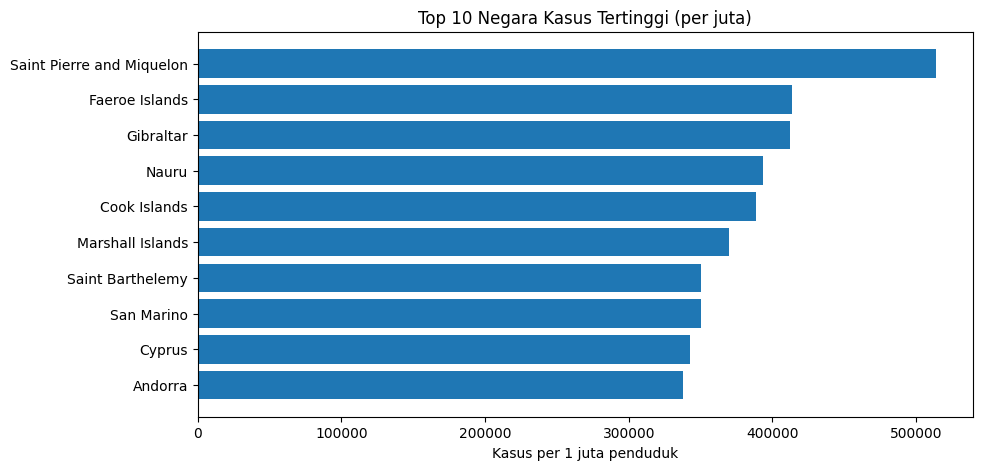

In [ ]:
top10 = global_mean.sort_values("cases_per_million", ascending=False).head(10)
top10
plt.figure(figsize=(10,5))
plt.barh(top10["location"], top10["cases_per_million"])
plt.xlabel("Kasus per 1 juta penduduk")
plt.title("Top 10 Negara Kasus Tertinggi (per juta)")
plt.gca().invert_yaxis()
plt.show()


3.4 Feature Engineering — Kategorisasi Risk Level

In [ ]:
q1 = global_mean["cases_per_million"].quantile(0.33)
q2 = global_mean["cases_per_million"].quantile(0.66)

def risk_category(x):
    if x <= q1: return "Low"
    elif x <= q2: return "Medium"
    return "High"

global_mean["risk_level"] = global_mean["cases_per_million"].apply(risk_category)
global_mean["risk_level"].value_counts()


,count
risk_level,
High,81
Low,79
Medium,78


3.5 Korelasi Kasus vs Kematian (Scatter Plot Global)

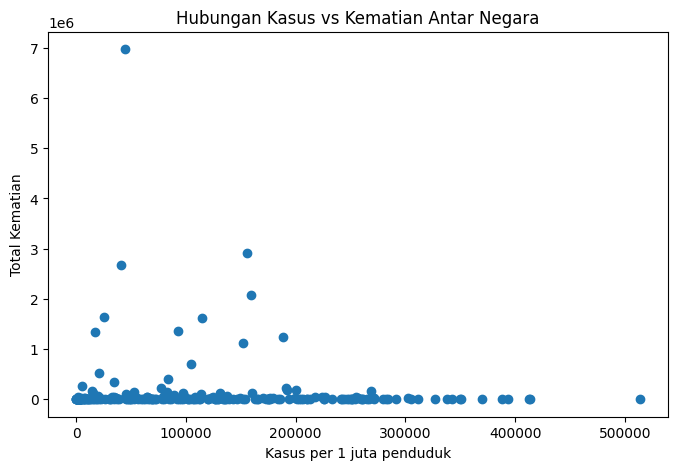

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(global_mean["cases_per_million"], global_mean["total_deaths"])
plt.xlabel("Kasus per 1 juta penduduk")
plt.ylabel("Total Kematian")
plt.title("Hubungan Kasus vs Kematian Antar Negara")
plt.show()


Ringkasan Statistik Global

In [ ]:
summary = global_mean[["cases_per_million","total_deaths","population"]].describe()
summary


,cases_per_million,total_deaths,population
count,238.000000,2.380000e+02,2.380000e+02
mean,111174.420507,1.223661e+05,1.355425e+08
std,107143.451403,5.745545e+05,6.805431e+08
min,247.139095,1.000000e+00,4.413000e+03
25%,14514.382645,2.397500e+02,5.993830e+05
50%,82073.274141,2.670000e+03,6.483507e+06
75%,179052.948206,2.017075e+04,3.236404e+07
max,513791.129992,6.972139e+06,7.975105e+09


$\textbf{5. PEMODELAN (LOGISTIC REGRESSION)} $ <br>

In [ ]:

# fitur & target
X = global_mean[["cases_per_million","total_deaths","population"]]
y = global_mean["risk_level"]

# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# training model
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

# prediksi
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

        High       1.00      0.94      0.97        16
         Low       0.94      1.00      0.97        16
      Medium       0.94      0.94      0.94        16

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



6. Insight & Kesimpulan Analisis
Insight Utama



Dampak pandemi antar negara tidak merata, dengan beberapa negara memiliki tingkat kasus jauh lebih tinggi.

Variabel cases_per_million terbukti menjadi indikator paling kuat dalam membedakan tingkat risiko.

Logistic Regression mampu memetakan negara ke dalam kelompok Low, Medium, dan High Risk secara cukup akurat.

Hasil pemodelan berpotensi digunakan untuk:
1.   monitoring kesiapsiagaan pandemi
2.   pengambilan kebijakan kesehatan global
3.   analisis prioritas mitigasi risiko




